# LocaleDB: Multivariate Time Series Clustering (Continuous Wavelet Transform)
---

Clustering attempts to suggest patterns in data by grouping similar items together.  This notebook demonstrates clustering of multivariate time series (MVTS) using methods based on the Continuous Wavelet Transform (CWT).  The time series in question are Covid-19 disease dynamics (specifically daily counts of confirmed cases and deaths in US counties).

## Environment
---

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

from localedb.localedb import LocaleDB
from localedb.util import plot_init, plot_ts
from localedb.clustering import cluster_aff_prop, cluster_kmedoids, dist_mat, plot_scalogram, plot_ts_clusters_all

db = LocaleDB().set_disease('COVID-19')

First, we declare variables and define convenience functions:

In [3]:
dis_dyn = ['n_conf', 'n_dead']  # disease dynamics time series

def get_data(fips='42___', cols=dis_dyn, day0=0, day1=99999, do_interpolate=True, n_diff=0, smooth_window_len=14):
    return np.array(db.get_dis_dyn_by_fips(fips, cols, day0, day1, do_interpolate, n_diff, smooth_window_len, do_scale=True)[0])

## Continuous Wavelet Transform
---

The CWT is a method for time-locating frequencies in a signal.  For example, a sinusoidal signal might oscilate with high frequency towards the beginning of the observation (or recording) window but those oscilation might slow towards the end of that window.  A related and perhaps more well-known Fourier Transform allows only to identify the presence of a frequency in a signal, but not that frequency's location.  The CWT works by passing a so-called mother wavelet across the signal and the CWT is the convolution of the two functions.  By scaling the mother wavelet, the CWT is able to locate frequencies.  That is, the value of the colvolution function will be larger where the frequency (actually scale) of the wavelet coinsides with that of the signal.  Two popular mother wavlets are the Ricker and the Morlet and they are plotted below.

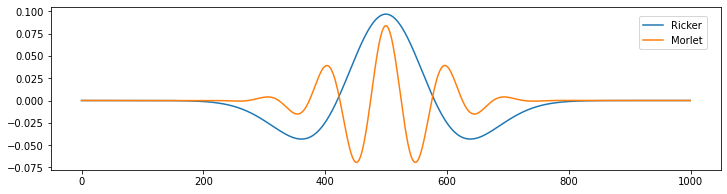

In [4]:
fig, ax = plt.subplots(1,1, figsize=(12,3))
ax.plot(scipy.signal.ricker(1000, 80.0), label='Ricker')
ax.plot(scipy.signal.morlet2(1000, 80.0, 5), label='Morlet')
fig.legend(loc='upper right', bbox_to_anchor=(0.89, 0.86), shadow=False, ncol=1)
plt.show()
del(fig, ax)

The Ricker wavelet is also known as the Maxican Hat wavelet due to it's characteristic shape.  Of course, the wavelets can be scaled.

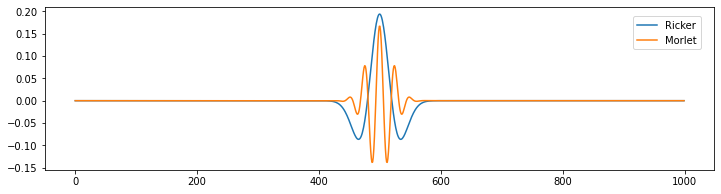

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,3))
ax.plot(scipy.signal.ricker(1000, 20.0), label='Ricker')
ax.plot(scipy.signal.morlet2(1000, 20.0, 5), label='Morlet')
fig.legend(loc='upper right', bbox_to_anchor=(0.89, 0.86), shadow=False, ncol=1)
plt.show()
del(fig, ax)

Let's use the standardized number of confirmed Covid-19 cases in the Alleghenty County, PA to illustrate the CWT using several mother wavelets.  First, we pull the data from the database.

In [6]:
a = db.get_dis_dyn_by_fips(fips='42003', cols=['n_conf'], do_interpolate=True, n_diff=1, smooth_window_len=28, do_scale=True)[0][0]
a.shape

(1, 546)

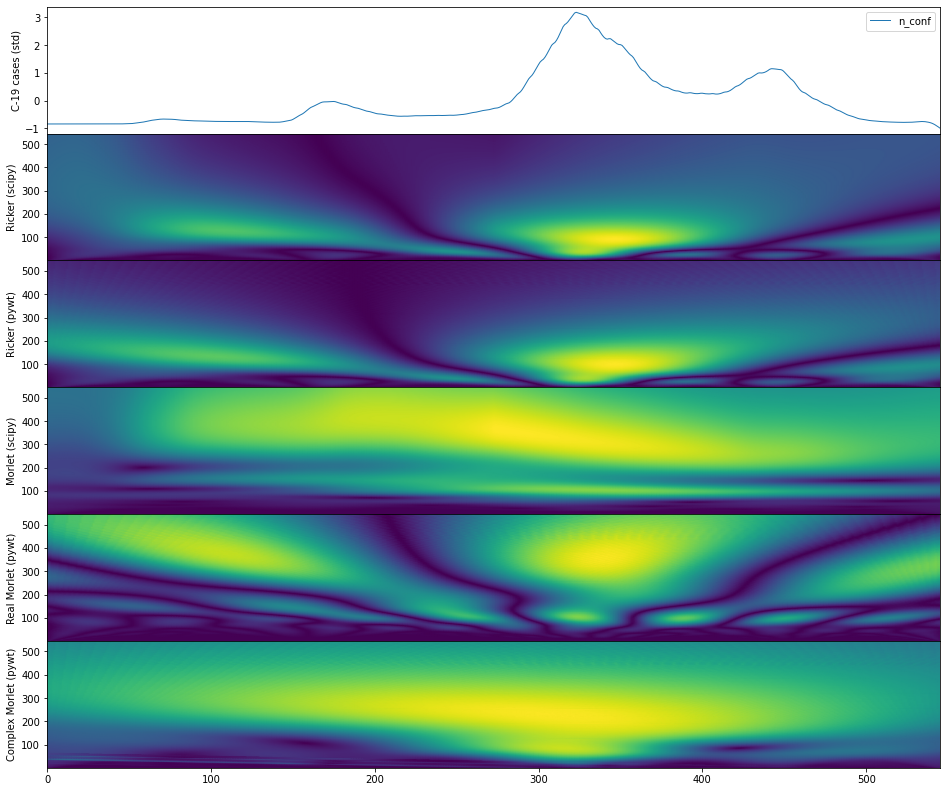

In [7]:
_, ax = plot_init(6, 1, (16,14), sharex=True)
_,_ = plot_ts(a, cols=['n_conf'], ylabel='C-19 cases (std)', ax=ax[0])
_,_ = plot_scalogram(a[0], scipy.signal.ricker, ylabel='Ricker (scipy)', ax=ax[1])
_,_ = plot_scalogram(a[0], 'mexh', ylabel='Ricker (pywt)', ax=ax[2])
_,_ = plot_scalogram(a[0], scipy.signal.morlet2, ylabel='Morlet (scipy)', ax=ax[3])
_,_ = plot_scalogram(a[0], 'morl', ylabel='Real Morlet (pywt)', ax=ax[4])
_,_ = plot_scalogram(a[0], 'cmor', ylabel='Complex Morlet (pywt)', ax=ax[5])
del(ax)

The confirmed cases time series has 546 observations.  The `plot_scalogram()` function will by default use all wavelet scales from 1 to 546 to compute the CWT.  That is, the scalograms above are 546x546.  Shown are CWT results from `scipy` and `pywt` packages as well as real- and complex-valued mother wavelets.  The scalogram takes a light yellow color when the wavelet with a given scale (the ordinate) convoles well with the signal around a given time (the abscissa).  For example, Ricker wavelets (panels 2 and 3) scaled at 10-150 convolve well with the confirmed cases time series around the 320-th day of the pandemic.

In [8]:
del(a)

## CWT-based Clustering
---

We now demonstrate how to cluster MVTS using a CTW-based method called SPCAms (for multiscale PCA similarity measure).  The method first computes spectrograms for every time series (using the desired vector of wavelet scales), then organizes those spectrograms by wavelet scale, and then computes the PCA similarity measure (SPCA) per wavelet scale.  The averaged SPCA measures give the overal similarity between the MVTS and its complement gives distance.  This is how a distance matrix used by clustering algorithms is computed.  More information can be found in [this publication](https://www.sciencedirect.com/science/article/abs/pii/S0360835216300560), but note that we use different type of wavelets and allow the user to choose the specific continuous wavlet.

We will cluster the 67 PA counties based on disease dynamics.  First, we pull the data from the database (standardized raw and standardized differenced).

In [9]:
ds_pa   = get_data('42___', n_diff=0, smooth_window_len=14)
ds_pa_d = get_data('42___', n_diff=1, smooth_window_len=28)

Next, we construct the distance matrix.  We use the complex Morlet wavelet.  In general, `scipy` does not handle complex numbers.  Clustering algorithms from `scipy.clustering` package are a good example.  To go around that, we could drop the imaginary component of all the distances in the distance matrix.  Instead, we will use their complex conjugates.

In [10]:
d_comp = dist_mat(ds_pa, metric='cwt-spca', wavelet=scipy.signal.morlet2)
d_real = np.real(d_comp * np.conj(d_comp))  # complex conjugate

Next, we cluster using affinity propagation and plot both the original and differenced time series associated with each cluster.

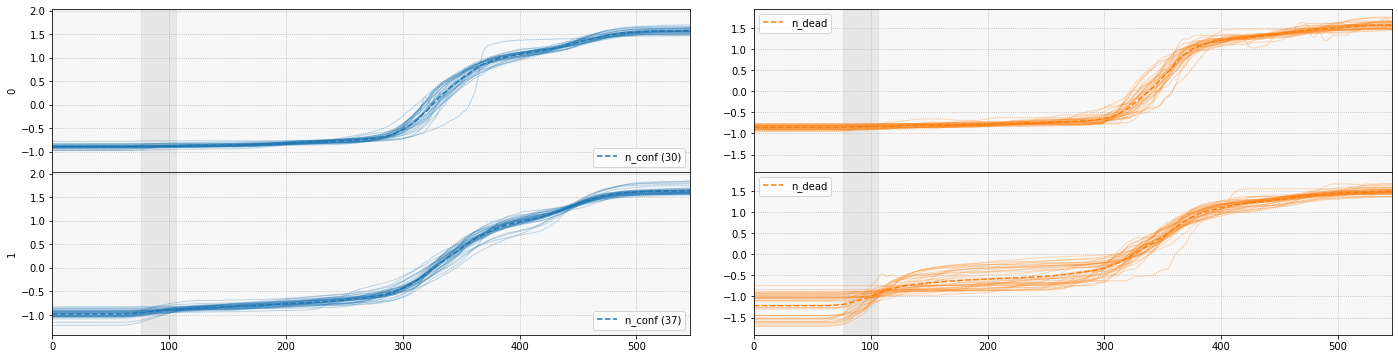

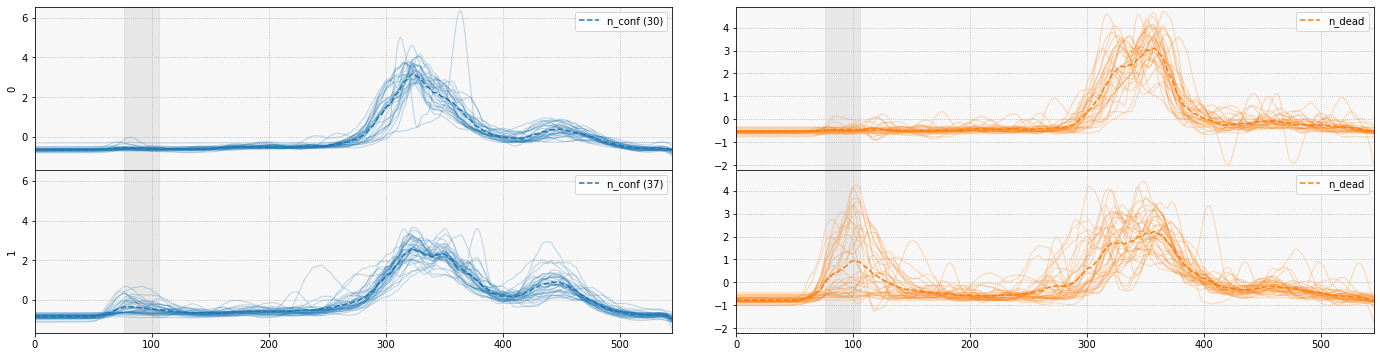

In [11]:
clustering_ap = cluster_aff_prop(d_real)

_ = plot_ts_clusters_all(ds_pa,   clustering_ap.labels_, 0, dis_dyn, None, False, True, True, True, ':', 12, 3, highlight_rect_xw=[(76,30)])
_ = plot_ts_clusters_all(ds_pa_d, clustering_ap.labels_, 0, dis_dyn, None, False, True, True, True, ':', 12, 3, highlight_rect_xw=[(76,30)])

Out fall two clusters with an approximately even split of counties (i.e., 30 vs 37).  Cluster 0 lacks the early increase in the number of confirmed cases (blue) and the much more pronounced number of deaths that begun around the 70th day of the pandemic.  Most of the counties hit by the pandemic early seem to be assigned to cluster 1.

Now, we cluster on the differenced data using the same wavelet.

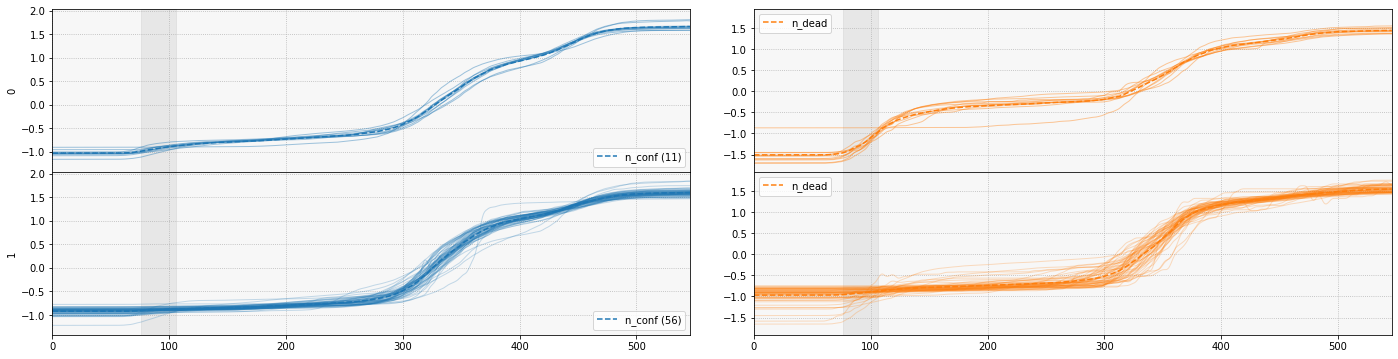

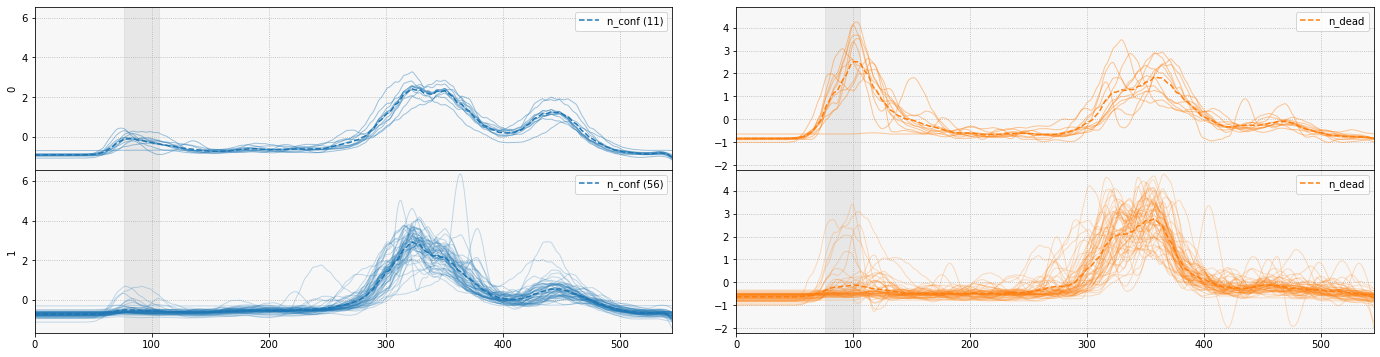

In [12]:
d_comp = dist_mat(ds_pa_d, metric='cwt-spca', wavelet=scipy.signal.morlet2)
d_real = np.real(d_comp * np.conj(d_comp))

clustering_ap = cluster_aff_prop(d_real)

_ = plot_ts_clusters_all(ds_pa,   clustering_ap.labels_, 0, dis_dyn, None, False, True, True, True, ':', 12, 3, highlight_rect_xw=[(76,30)])
_ = plot_ts_clusters_all(ds_pa_d, clustering_ap.labels_, 0, dis_dyn, None, False, True, True, True, ':', 12, 3, highlight_rect_xw=[(76,30)])

We still get two clusters, but now cluster 0 is about 1/5 the size of the second one.  The results do look a bit cleaner, but more analysis would need to be carried out to confirm or disprove that.

Finally, let's try the complex Morlet wavelet from the `pywt` package.

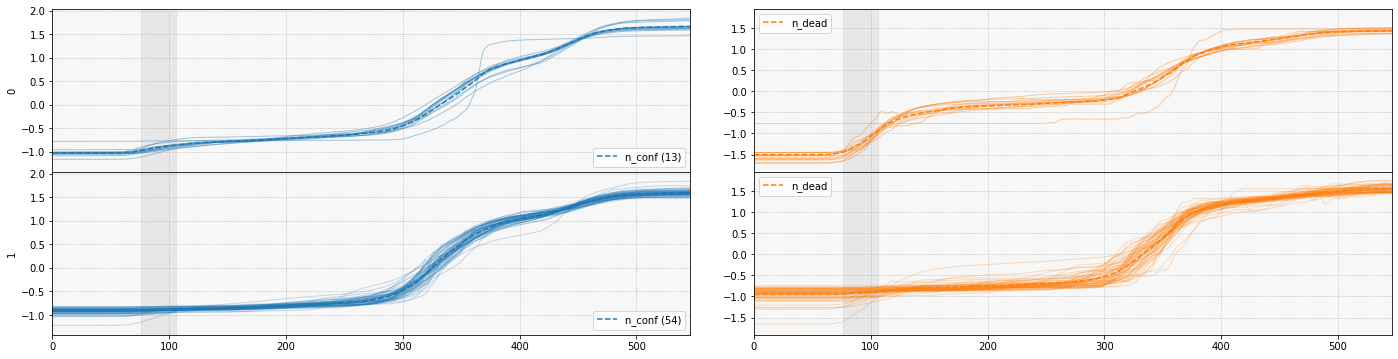

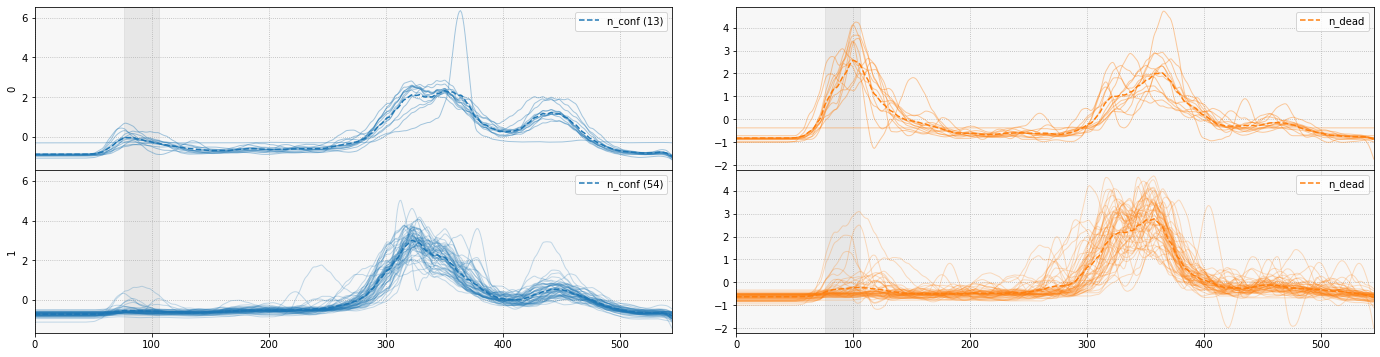

In [13]:
d_comp  = dist_mat(ds_pa_d, metric='cwt-spca', wavelet='cmor')
d_real = np.real(d_comp * np.conj(d_comp))

clustering_ap = cluster_aff_prop(d_real)

_ = plot_ts_clusters_all(ds_pa,   clustering_ap.labels_, 0, dis_dyn, None, False, True, True, True, ':', 12, 3, highlight_rect_xw=[(76,30)])
_ = plot_ts_clusters_all(ds_pa_d, clustering_ap.labels_, 0, dis_dyn, None, False, True, True, True, ':', 12, 3, highlight_rect_xw=[(76,30)])

The results diverge slightly between `scipy` and `pywt` wavelets, but the overall trend that emerges from using both seems consistent.

We finish with a proper cleanup:

In [14]:
del(clustering_ap, d_comp, d_real, ds_pa, ds_pa_d, db)